In [28]:
import pandas as pd

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_excel('Online Retail.xlsx')


df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Remove rows where any essential field is missing (e.g., CustomerID, Quantity, UnitPrice)
df = df.dropna(subset=['CustomerID', 'Quantity', 'UnitPrice'])

# Remove duplicates
df = df.drop_duplicates()

# Ensure that 'InvoiceDate' is a datetime object
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Inspect the cleaned data
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [ ]:
# Create a snapshot date (latest date in the dataset)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate Recency, Frequency, and Monetary features for each customer
rfm_df = df.groupby('CustomerID').agg(
    recency = pd.NamedAgg(column='InvoiceDate', aggfunc=lambda x: (snapshot_date - x.max()).days),
    frequency = pd.NamedAgg(column='InvoiceNo', aggfunc='nunique'),
    monetary = pd.NamedAgg(column='Quantity', aggfunc='sum')
)


rfm_df.head()


,recency,frequency,monetary
CustomerID,,,
12346.0,326,2,0
12347.0,2,7,2458
12348.0,75,4,2341
12349.0,19,1,631
12350.0,310,1,197


In [32]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df)

# Convert it back to a DataFrame
rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=rfm_df.columns)

# Inspect the normalized data
rfm_normalized_df.head()


,recency,frequency,monetary
0,2.322023,-0.329362,-0.239517
1,-0.893733,0.206102,0.286544
2,-0.169196,-0.115176,0.261504
3,-0.725005,-0.436455,-0.104470
4,2.163220,-0.436455,-0.197355


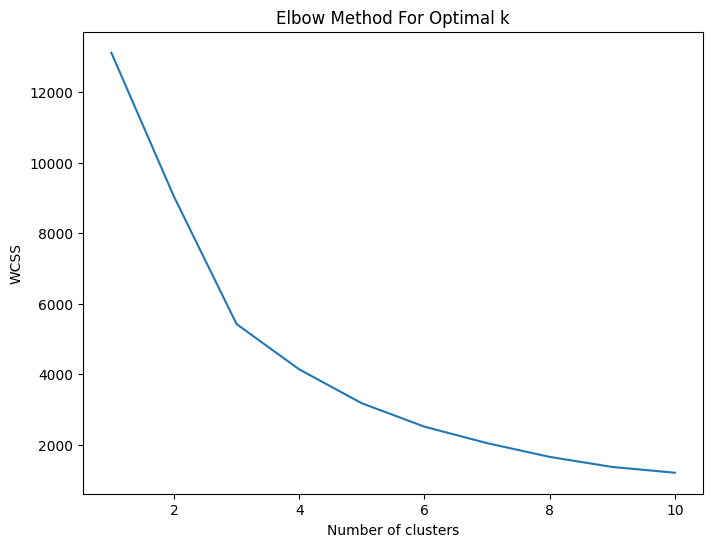

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_normalized_df)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values to determine the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [34]:
# Apply K-Means with the chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized_df)

# Show the resulting clusters
rfm_df.head()


,recency,frequency,monetary,Cluster
CustomerID,,,,
12346.0,326,2,0,1
12347.0,2,7,2458,0
12348.0,75,4,2341,0
12349.0,19,1,631,0
12350.0,310,1,197,1


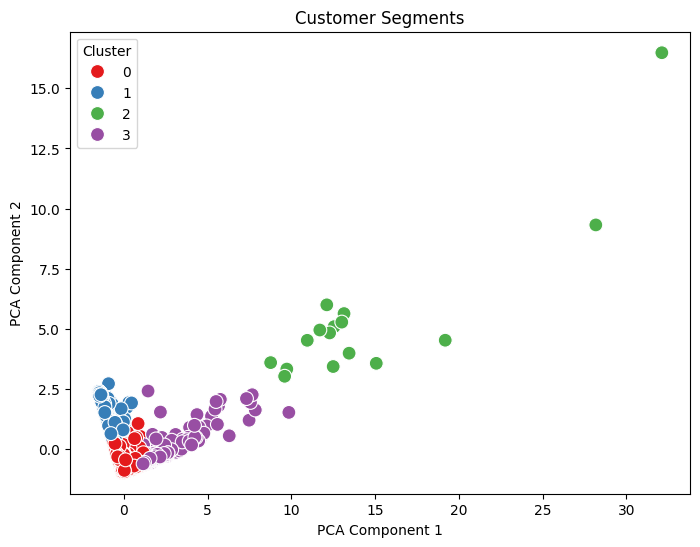

In [35]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_normalized_df)

# Add PCA components to the dataframe
rfm_df['PCA1'] = rfm_pca[:, 0]
rfm_df['PCA2'] = rfm_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100)
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
